#### Dataset: 
https://www.kaggle.com/dansbecker/cityscapes-image-pairs

## 1. Setup

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
from sklearn.metrics import label_ranking_average_precision_score 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
# import torchvision.datasets as datasets
# import os
# import random

# # Define the paths for downloading and extracting the dataset
# data_dir = '/path/to/your/data/directory'
# train_dir = os.path.join(data_dir, 'train')
# test_dir = os.path.join(data_dir, 'test')

# # Create the directories if they don't exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Download and extract the Cityscapes dataset
# cityscapes_train = datasets.Cityscapes(data_dir, split='train', mode='fine', target_type='semantic')
# cityscapes_test = datasets.Cityscapes(data_dir, split='val', mode='fine', target_type='semantic')

# # Get the list of images
# train_images = cityscapes_train.images
# test_images = cityscapes_test.images

# # Randomly select 3500 images for training and 1500 images for test
# random.shuffle(train_images)
# random.shuffle(test_images)

# selected_train_images = train_images[:3500]
# selected_test_images = test_images[:1500]

# # Move the selected images to the train and test directories
# for img_path in selected_train_images:
#     img_name = os.path.basename(img_path)
#     os.rename(img_path, os.path.join(train_dir, img_name))

# for img_path in selected_test_images:
#     img_name = os.path.basename(img_path)
#     os.rename(img_path, os.path.join(test_dir, img_name))

# print("Dataset preparation complete.")


In [4]:
data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


## 2. Analyze data

/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1269.jpg


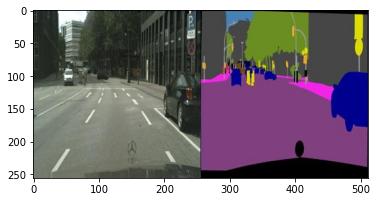

In [5]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [6]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


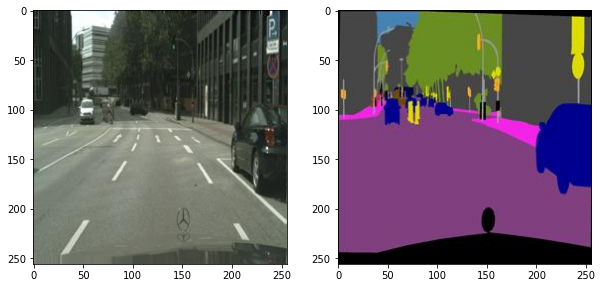

In [7]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

## 3. Define Labels

In [8]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[138 176 141]
 [118 125 129]
 [ 71  21 181]
 [225  10 112]
 [224 218  97]]


In [9]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [10]:
label_model.predict(color_array[:5, :])

array([9, 9, 7, 2, 8], dtype=int32)

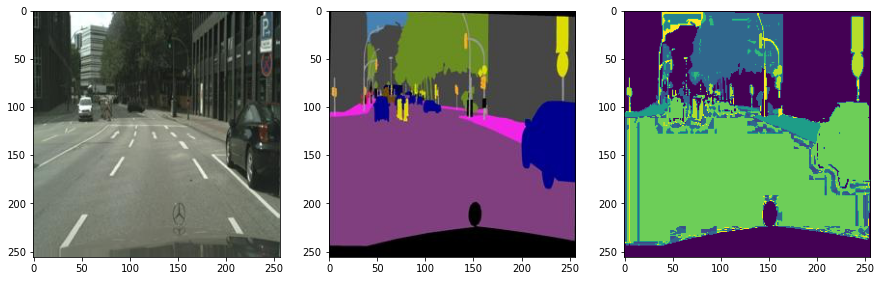

In [11]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [12]:
label_class

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

## 4. Define Dataset

In [13]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [14]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [15]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


## 5. Define Model

In [16]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [17]:
model = UNet(num_classes=num_classes)

In [18]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [19]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


## 6. Train the model

In [20]:
batch_size = 16
epochs = 30
lr = 0.01

In [21]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [22]:
dataset = CityscapeDataset(val_dir, label_model)
test_loader = DataLoader(dataset, batch_size=batch_size)

In [23]:
model = UNet(num_classes=num_classes).to(device)

In [24]:
# Define a function to calculate Mean Average Precision (mAP)
def mean_average_precision(y_pred, y_true):
    y_pred = y_pred.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    return average_precision_score(y_true, y_pred_proba, average='macro')

In [25]:
def dice_loss(output, target):
    smooth = 1e-6
    output_flat = output.view(-1)
    target_flat = target.view(-1)
    intersection = (output_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (output_flat.sum() + target_flat.sum() + smooth)
    return 1 - dice

In [26]:
def calculate_ap(Y_pred, Y):
    total_ap = 0.0
    total_samples = 0

    for i in range(Y_pred.shape[0]):
        # Flatten the 256x256 predictions and labels for each image in the batch
        pred = Y_pred[i].flatten()
        label = Y[i].flatten()

        # Calculate true positive, false positive, and total positive pixels
        tp = torch.sum((pred == label) & (pred != 0)).item()
        fp = torch.sum((pred != label) & (pred != 0)).item()
        total_positive = torch.sum(label != 0).item()

        # Calculate precision for this image
        if tp + fp == 0:
            precision = 0.0
        else:
            precision = tp / (tp + fp)

        # Update total AP and total samples
        total_ap += precision
        total_samples += 1

    # Calculate Average Precision
    ap = total_ap / total_samples
    return ap

In [27]:
# def combined_loss(output, target):
#     return nn.NLLLoss(output, target) + dice_loss(F.softmax(output, dim=1)[:, 1].reshape(-1), target.float())

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [29]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))
    # Calculate DICE Score and Mean Average Precision on test set
    with torch.no_grad():
        dice_scores = []
        average_precisions = []
        # inputs, targets
        for X, Y in tqdm(test_loader, total=len(test_loader), leave=False):
            X, Y = X.to(device), Y.to(device)
            Y_pred = model(X)
            Y_pred = torch.argmax(Y_pred, dim=1)
            dice_scores.append(dice_loss(Y_pred, Y))
            Y_pred_float = Y_pred.float()  # Convert to float tensor
            average_precisions.append(calculate_ap(Y_pred_float, Y))

        mean_dice_score = sum(dice_scores) / len(dice_scores)
        mean_average_precision_score = sum(average_precisions) / len(average_precisions)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, DICE Score: {mean_dice_score}, Mean Average Precision: {mean_average_precision_score}")

Epoch 1/30, Loss: 1.0134930610656738, DICE Score: -4.27198600769043, Mean Average Precision: 0.6520913901136888


Epoch 2/30, Loss: 0.9117664098739624, DICE Score: -4.301535129547119, Mean Average Precision: 0.6814406261079075


Epoch 3/30, Loss: 0.8191751837730408, DICE Score: -4.406458377838135, Mean Average Precision: 0.6950820351693058


Epoch 4/30, Loss: 0.7572449445724487, DICE Score: -4.501906871795654, Mean Average Precision: 0.712199454476812


Epoch 5/30, Loss: 0.7152444124221802, DICE Score: -4.512967586517334, Mean Average Precision: 0.7293512612911834


Epoch 6/30, Loss: 0.6773126721382141, DICE Score: -4.536893844604492, Mean Average Precision: 0.739738904331147


Epoch 7/30, Loss: 0.6597492098808289, DICE Score: -4.552310466766357, Mean Average Precision: 0.7441079909151911


Epoch 8/30, Loss: 0.6342045068740845, DICE Score: -4.549741744995117, Mean Average Precision: 0.7537672873851756


Epoch 9/30, Loss: 0.6089538931846619, DICE Score: -4.549709320068359, Mean Average Precision: 0.7508722548961695


Epoch 10/30, Loss: 0.5810648798942566, DICE Score: -4.560230255126953, Mean Average Precision: 0.7561204313750727


Epoch 11/30, Loss: 0.5987129211425781, DICE Score: -4.552685260772705, Mean Average Precision: 0.7528458520518956


Epoch 12/30, Loss: 0.5538999438285828, DICE Score: -4.559747695922852, Mean Average Precision: 0.7666034986577331


Epoch 13/30, Loss: 0.5336802005767822, DICE Score: -4.556303024291992, Mean Average Precision: 0.7709260517333216


Epoch 14/30, Loss: 0.5113179087638855, DICE Score: -4.586889266967773, Mean Average Precision: 0.770770119799522


Epoch 15/30, Loss: 0.5008915662765503, DICE Score: -4.581892013549805, Mean Average Precision: 0.7757092256859933


Epoch 16/30, Loss: 0.4522424042224884, DICE Score: -4.595574855804443, Mean Average Precision: 0.7880211217376226


Epoch 17/30, Loss: 0.44396620988845825, DICE Score: -4.584266185760498, Mean Average Precision: 0.7917473071039335


Epoch 18/30, Loss: 0.43087634444236755, DICE Score: -4.601262092590332, Mean Average Precision: 0.7880322039190798


Epoch 19/30, Loss: 0.3921133577823639, DICE Score: -4.572662353515625, Mean Average Precision: 0.7958318530725224


Epoch 20/30, Loss: 0.3668961226940155, DICE Score: -4.593869686126709, Mean Average Precision: 0.7949759695853468


Epoch 21/30, Loss: 0.35986199975013733, DICE Score: -4.599305152893066, Mean Average Precision: 0.7909423104920277


Epoch 22/30, Loss: 0.34783050417900085, DICE Score: -4.624420166015625, Mean Average Precision: 0.7821901308032243


Epoch 23/30, Loss: 0.32082080841064453, DICE Score: -4.628927707672119, Mean Average Precision: 0.7839278824529395


Epoch 24/30, Loss: 0.30531391501426697, DICE Score: -4.646854877471924, Mean Average Precision: 0.797374508887016


Epoch 25/30, Loss: 0.29913604259490967, DICE Score: -4.633288860321045, Mean Average Precision: 0.8060307894765721


Epoch 26/30, Loss: 0.2875829339027405, DICE Score: -4.631735801696777, Mean Average Precision: 0.8032447605011324


Epoch 27/30, Loss: 0.2979801297187805, DICE Score: -4.633327484130859, Mean Average Precision: 0.7981012587930365


Epoch 28/30, Loss: 0.2739851176738739, DICE Score: -4.630856990814209, Mean Average Precision: 0.7965128351185865


Epoch 29/30, Loss: 0.28970977663993835, DICE Score: -4.645493984222412, Mean Average Precision: 0.7922548370866773


Epoch 30/30, Loss: 0.3043934404850006, DICE Score: -4.644899845123291, Mean Average Precision: 0.7854423388386125



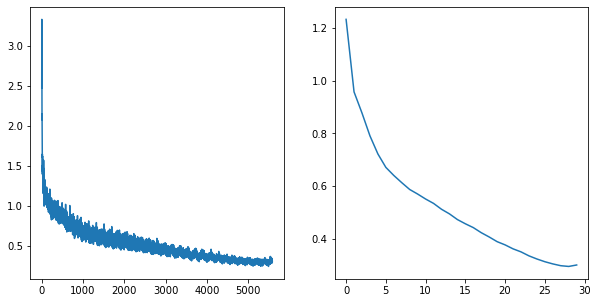

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [31]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

## 7. Check model predictions

In [32]:
model_path = "/kaggle/working/U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [33]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [34]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [35]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

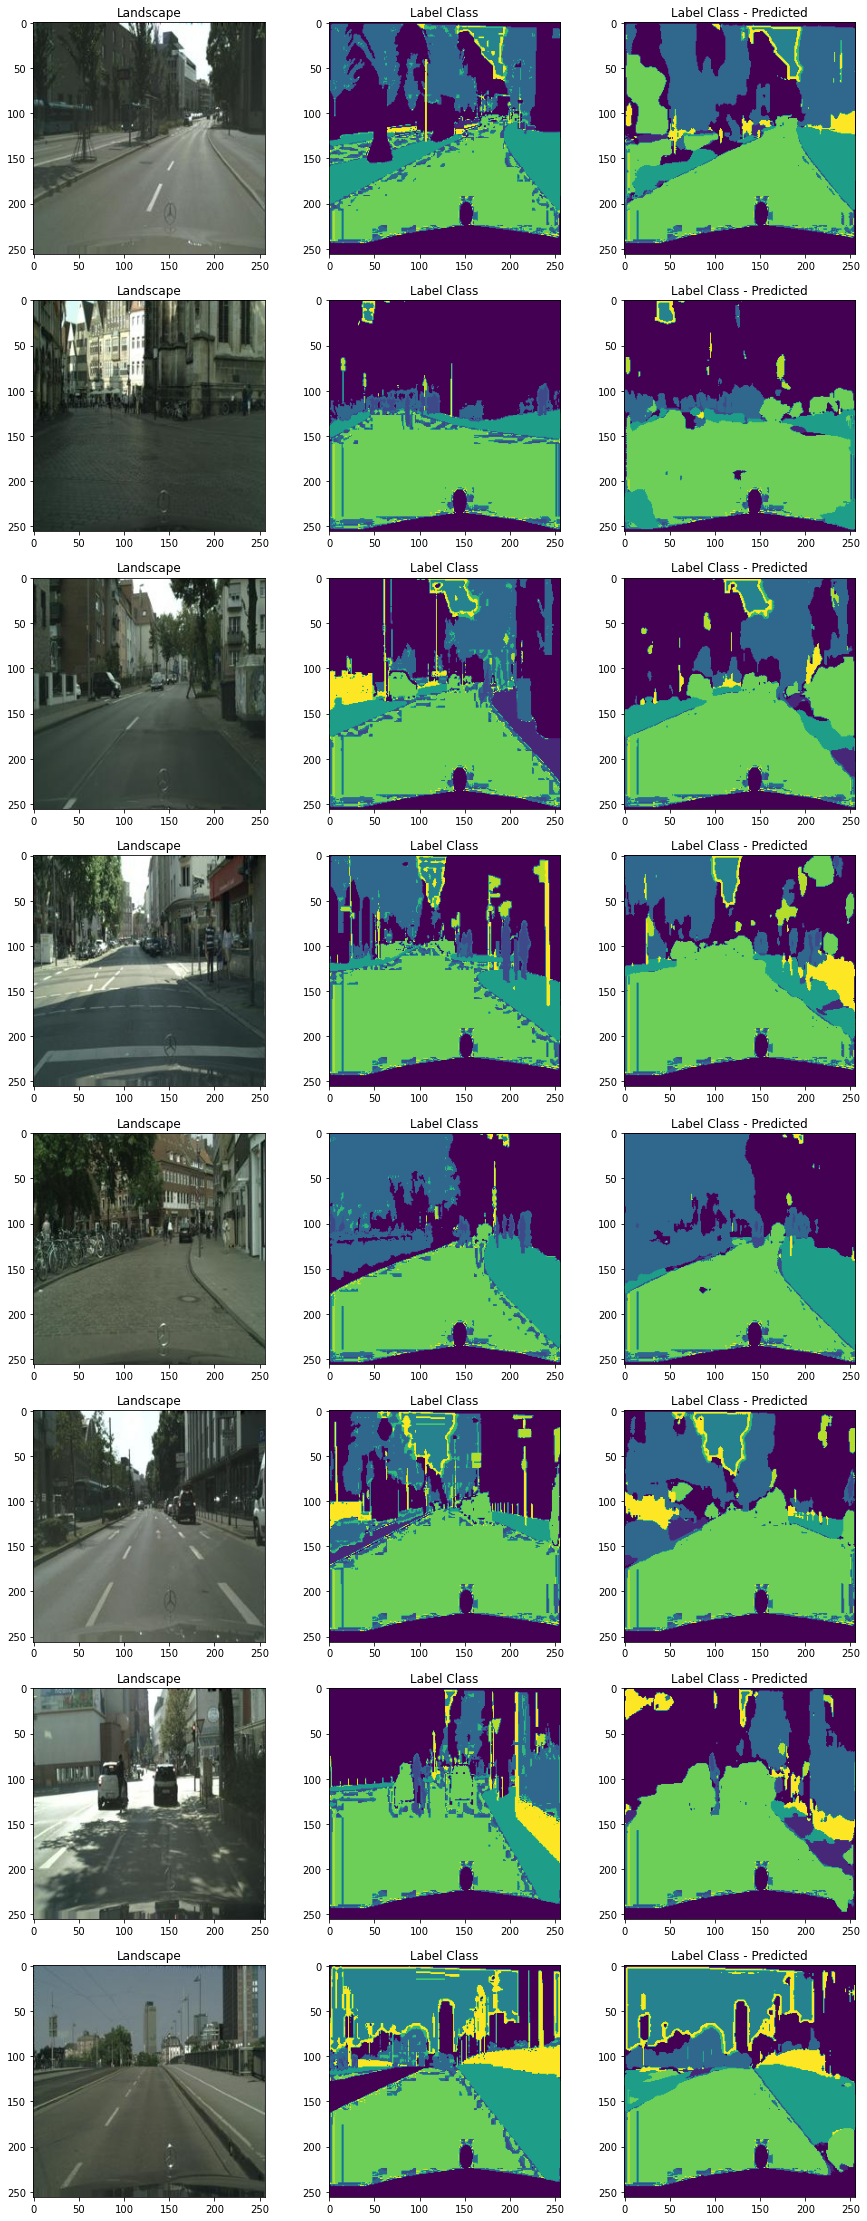

In [36]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")